## Data validation for GRIDCERF solar technologies

In [1]:
%matplotlib inline 

import os
import glob
import shutil
import tempfile

import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio.mask
import seaborn as sns
import shapely.speedups
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio import features
from rasterio.plot import show, plotting_extent
from tqdm import tqdm

# enable shapely.speedups to make the spatial queries run faster
shapely.speedups.enable()


### Worker functions

In [2]:
def sum_rasters(raster_list) -> np.ndarray:
    """Sum all rasters in the input list and return a reclassified array having
    values of 0 == suitable and 1 == unsuitable.
    
    :param raster_list:                 List of full path with file name and extensions to the input raster files
    :type raster_list:                  list 
    
    :return:                            A 2D array of 0, 1 suitablity designation
    
    """
    
    for idx, raster in enumerate(raster_list):

        if idx == 0:
            final_array = raster_to_array(raster).astype(np.float32)

        else:

            this_array = raster_to_array(raster)
            final_array += this_array
                
    # reclassify array back to 0 == suitable, 1 == unsuitable
    return np.where(final_array == 0, 0, 1)
    

def raster_to_array(raster_file) -> np.ndarray:
    """Read in a raster file and return a 2D NumPy array.
    
    :param raster_file:                 Full path with file name and extension to the input raster file 
    :type raster_file:                  str 
    
    :return:                            A 2D array
    
    """
    
    with rasterio.open(raster_file) as src:
        return src.read(1)

    
def plot_raster(arr, title):

    fig, ax = plt.subplots(figsize=(10, 5))

    # Define the colors you want
    cmap = ListedColormap(["grey", "navy"])

    # Define a normalization from values -> colors
    norm = colors.BoundaryNorm([0, 1], 2)

    raster_plot = ax.imshow(arr, cmap=cmap)

    # Add a legend for labels
    legend_labels = {"grey": "0", "navy": "1"}

    patches = [Patch(color=color, label=label)
               for color, label in legend_labels.items()]

    ax.legend(handles=patches,
              bbox_to_anchor=(1.15, 1),
              facecolor="white")

    ax.set_title(title)

    ax.set_axis_off()
    
    return ax
    

### Load data

In [3]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# validation directory
validation_dir = os.path.join(gridcerf_dir, 'validation')

# common exclusion layers
raster_dir = os.path.join(gridcerf_dir, 'common')

# directory containing technology specific layers
tech_dir = os.path.join(gridcerf_dir, 'technology_specific')

# template land mask raster
template_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# additional layers needed
slope_raster = os.path.join(tech_dir, 'gridcerf_srtm_slope_10pct_or_less.tif')
potential_raster = os.path.join(tech_dir, 'gridcerf_nrel_solar_pv_centralized_potential.tif')
population_raster = os.path.join(tech_dir, 'gridcerf_densely_populated_ssp2_2020.tif')

# EIA power plant spatial data
power_plant_file = os.path.join(validation_dir, 'eia', 'accessed_2021-06-09', 'PowerPlants_US_EIA', 'PowerPlants_US_202004.shp')

# eia generatory inventory file downloaded from:  https://www.eia.gov/electricity/data/eia860m/xls/april_generator2021.xlsx
eia_generator_inventory_file = os.path.join(validation_dir, 'eia', 'april_generator2021.xlsx')

# eia 923 generation data downloaded from: https://www.eia.gov/electricity/data/eia923/archive/xls/f923_2021.zip
eia_generation_file = os.path.join(validation_dir, "eia", "EIA923_Schedules_2_3_4_5_M_12_{}_Final_Revision.xlsx")

# administrative data
cerf_conus_file = os.path.join(reference_dir, 'gridcerf_conus_boundary.shp')
cerf_states_file = os.path.join(reference_dir, 'Promod_20121028_fips.shp')

# output combined suitability layer without land mask
cerf_suitability_file = os.path.join(validation_dir, 'temp', 'gridcerf_solar_suitability_nomask.tif')

# combined suitability with land mask
cerf_suitability_masked_file = os.path.join(validation_dir, 'temp', 'gridcerf_solar_suitability_landmask.tif')

# validation outputs
suitable_power_plants_file = os.path.join(validation_dir, 'results', 'suitable_power_plants_solar.shp')
unsuitable_power_plants_file = os.path.join(validation_dir, 'results', 'unsuitable_power_plants_solar.shp')


### Create raster mask for CONUS grid cells

In [4]:
with rasterio.open(template_raster) as src:
    
    land_mask_arr = src.read(1)
    mask_metadata = src.meta
    
    land_mask_arr = np.where(land_mask_arr == src.nodata, np.nan, 0)


### Generate a list of all solar suitablity rasters and extract the CRS info

In [5]:
raster_list = [os.path.join(raster_dir, i) for i in os.listdir(raster_dir) if os.path.splitext(i)[-1] in ('.tif', '.img')]
raster_list.append(potential_raster)
raster_list.append(slope_raster)
raster_list.append(population_raster)

# extract the coordinate reference system from CERF's raster
with rasterio.open(raster_list[0]) as src:
    target_crs = src.crs


In [6]:
raster_list

['/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_wdpa_state_protected_lands_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_blm_nlcs_national_monument_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_blm_nlcs_wilderness_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_usfws_critical_habitat_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_usgs_padus_class_1_to_2_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_usgs_wilderness_areas_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_wdpa_tnc_managed_lands_conus.tif',
 '/Users/d3y010/repos/metarepos/vernon-etal_2022_scidata/data/gridcerf/common/gridcerf_blm_nlcs_outstanding_natural_areas_conus.tif',
 '/User

### Create aggregate suitablity over the CONUS

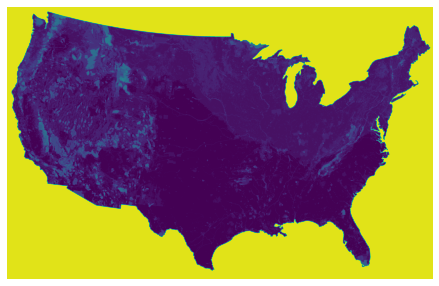

<AxesSubplot:>

In [7]:
for idx, raster in enumerate(raster_list):

    with rasterio.open(raster) as src:
        metadata = src.meta
        
        if idx == 0:
            arr = src.read(1).astype(np.uint8)
            
        else:
            arr += src.read(1).astype(np.uint8)
            
# create common combined exclusion array
common_arr = np.where(arr == 0, 0, 1).astype(rasterio.int16)

# write aggregate common suitability as a raster have 0 for suitable, 1 for unsuitable
with rasterio.open(cerf_suitability_file, 'w', **metadata) as out:
    out.write(common_arr, 1)
    

# plot aggregate suitablity
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_axis_off()
show(arr + land_mask_arr, ax)


### Create masked suitablity layer

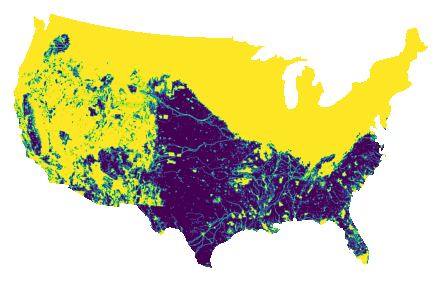

<AxesSubplot:>

In [8]:
mask_metadata.update({'dtype': 'float64'})

# generate a land mask where land == 1 and other == nan
with rasterio.open(template_raster) as src:
    arr = src.read(1)
    nodata_land = np.where(arr == 0, np.nan, arr)

# write common raster incorporating land mask
with rasterio.open(cerf_suitability_masked_file, 'w', **mask_metadata) as out:
    out.write((common_arr + land_mask_arr) * nodata_land, 1)

# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_axis_off()
show((common_arr + land_mask_arr) * nodata_land, ax)


### Read in EIA power plant and GRIDCERF boundary shapefiles to GeoDataFrames

Reproject the data to GRIDCERF's projected coordinate system

In [9]:
power_plant_gdf = gpd.read_file(power_plant_file).to_crs(target_crs)

boundary_gdf = gpd.read_file(cerf_conus_file).to_crs(target_crs)

states_gdf = gpd.read_file(cerf_states_file).to_crs(target_crs)


### Filter out only solar primary sources

In [10]:
# extract wind power plants
power_plant_gdf = power_plant_gdf.loc[power_plant_gdf['PrimSource'] == 'solar'].copy()





### Only keep power plants that are within GRIDCERF's CONUS extent

In [11]:
# get power plants that are within GRIDCERF's CONUS boundary
power_plant_mask = power_plant_gdf.within(boundary_gdf.loc[0, 'geometry'])
power_plant_conus = power_plant_gdf.loc[power_plant_mask].copy()


### Only keep solar installations that became operational during or after 2000

In [12]:
# load EIA montly generator inventory
gen_df = pd.read_excel(eia_generator_inventory_file, 
                       sheet_name='Operating', 
                       engine='openpyxl', 
                       skiprows=2, 
                       usecols=['Plant ID', 'Operating Year'])

# reduce eia860 data to only include plant if the first generator was operational during or after 2000
gen_df = gen_df.groupby('Plant ID', as_index=False).min()

# keep only operational during or after 2000
gen_df = gen_df.loc[gen_df['Operating Year'] >= 2000].copy()

# generate a dictionary of plant id to operating year
gen_df["Plant ID"] = gen_df["Plant ID"].astype(int)
id_to_oper_yr = gen_df.set_index("Plant ID")["Operating Year"].to_dict()

# get an array of 'Plant_Code' that meet the criteria
valid_plant_codes = gen_df['Plant ID'].unique().astype(int)

# only keep valid power plants
power_plant_conus = power_plant_conus.loc[power_plant_conus['Plant_Code'].isin(valid_plant_codes)].copy()

# extract x,y coords to list of tuples
power_plant_conus['xcoord'] = power_plant_conus.geometry.x
power_plant_conus['ycoord'] = power_plant_conus.geometry.y


### Reduce which power plants will be considered due to their capacity factor as it relates to our technical potential layer

In [13]:
capacity_factor_threshold = 0.23

# read in all years generation in mwh an combine into a single df
for i in tqdm(range(2015, 2021 + 1, 1)):
    
    # load EIA montly generator inventory
    generation_dfx = pd.read_excel(eia_generation_file.format(i), 
                           sheet_name='Page 1 Generation and Fuel Data', 
                           engine='openpyxl', 
                           skiprows=5, 
                           usecols=['Plant Id', "Net Generation\n(Megawatthours)", "Reported\nPrime Mover"])

    generation_dfx.rename(columns={
        "Plant Id": "plant_id", 
        "Net Generation\n(Megawatthours)": "generation_mwh", 
        "Reported\nPrime Mover": "fuel_code"
    }, inplace=True)
    
    generation_dfx["yr"] = i
    
    # only keep plants in the previouly filtered result
    generation_dfx = generation_dfx.loc[generation_dfx["plant_id"].isin(power_plant_conus["Plant_Code"].unique())].copy()
    
    # only keep solar generation
    generation_dfx = generation_dfx.loc[generation_dfx["fuel_code"] == "PV"].copy()
    
    # add operating year to generator df
    generation_dfx["operating_yr"] = generation_dfx["plant_id"].map(id_to_oper_yr)

    # only keep data from operating year + 1 year so we ensure we have full year records represented in the total generation
    generation_dfx = generation_dfx.loc[i >= (generation_dfx["operating_yr"] + 1)].copy()

    if i == 2015:
        generation_df = generation_dfx.copy()
    else:
        generation_df = pd.concat([generation_df, generation_dfx])

# calculate the mean generation for all years
generation_df = generation_df.groupby("plant_id").mean().reset_index()[["plant_id", "generation_mwh"]].copy()


100%|██████████| 7/7 [02:24<00:00, 20.70s/it]


In [14]:
# add solar mw to generation df
plant_to_mw_dict = power_plant_gdf.set_index("Plant_Code")["Solar_MW"].to_dict()
generation_df["mw"] = generation_df["plant_id"].map(plant_to_mw_dict)

generation_df = generation_df.loc[~generation_df["mw"].isna()].copy()

# generation_df["cf"] = (generation_df["generation_mwh"] / ((generation_df["mw"] / 1.3) * 8760)) 
generation_df["cf"] = (generation_df["generation_mwh"] / (generation_df["mw"] * 8760))

keep_plants_cf = generation_df.loc[generation_df["cf"] >= capacity_factor_threshold]["plant_id"].unique()

# only keep sites meeting capacity factor threshold
power_plant_gdf = power_plant_gdf.loc[power_plant_gdf["Plant_Code"].isin(keep_plants_cf)].copy()

# update power plants df to only keep valid generators
power_plant_conus = power_plant_conus.loc[power_plant_conus["Plant_Code"].isin(keep_plants_cf)].copy()


### Visualize all EIA power plants with applicable technologies over GRIDCERF's CONUS extent

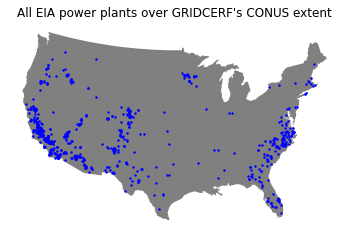

In [15]:
fig, ax = plt.subplots()
plt.title("All EIA power plants over GRIDCERF's CONUS extent")

boundary_gdf.plot(ax=ax, facecolor='gray')
power_plant_gdf.plot(ax=ax, color='blue', markersize=2)

ax.set_axis_off()


### Only keep solar installations >= 50 MW to represent a large solar PV installation


In [16]:
# power_plant_conus = power_plant_conus.loc[power_plant_conus['Solar_MW'] >= 50].copy()
power_plant_conus = power_plant_conus.loc[power_plant_conus['Solar_MW'] >= 50].copy()


### Visualize EIA solar installations that are within GRIDCERF's CONUS extent

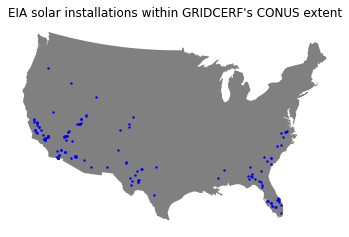

In [17]:
fig, ax = plt.subplots()
plt.title("EIA solar installations within GRIDCERF's CONUS extent")

boundary_gdf.plot(ax=ax, facecolor='gray')
power_plant_conus.plot(ax=ax, color='blue', markersize=2)

ax.set_axis_off()


Text(0, 0.5, 'Count')

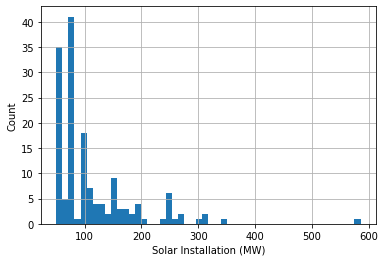

In [18]:
ax = power_plant_conus['Solar_MW'].hist(bins=50)
ax.set_xlabel("Solar Installation (MW)")
ax.set_ylabel("Count")


## Determine which solar installations fall on suitable and unsuitable land

### Validation for individual solar suitablity layers for the CONUS

In [20]:
# get a list of coordinates for suitable power plants
coords = [(x,y) for x, y in zip(power_plant_conus['xcoord'], power_plant_conus['ycoord'])]

# dictionary to store outputs in
d = {'layer': [], 'invalid': [], 'valid': []}

# total number of power plants for the CONUS
n_power_plants_conus = len(coords)

# update suitability for each power plant once it is within a grid cell that is unsuitable
for raster in raster_list:

    with rasterio.open(raster) as src:

        # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
        extract_suitability_at_points = [int(i[0]) for i in src.sample(coords)]
        
        # get the count of unsuitable designations
        n_unsuitable_plants = len([i for i in extract_suitability_at_points if i == 1])
        
        # append the results to the output dictionary
        d['layer'].append(os.path.basename(raster.lower()))
        d['invalid'].append(n_unsuitable_plants)
        d['valid'].append(n_power_plants_conus - n_unsuitable_plants)

# convert the output to a pandas data frame
layer_specific_diagnostics = pd.DataFrame(d)

layer_specific_diagnostics['fraction'] = layer_specific_diagnostics['invalid'] / n_power_plants_conus


### Validation for all common suitability layers combined

In [21]:

# stage suitability designation for each power plant
power_plant_conus['suitability'] = 0

# update suitability for each power plant once it is within a grid cell that is unsuitable
for raster in raster_list:

    with rasterio.open(raster) as src:

        # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
        extract_suitability_at_points = [int(i[0]) for i in src.sample(coords)]

    # if unsuitable, update value
    power_plant_conus['suitability'] = np.where(power_plant_conus['suitability'] < extract_suitability_at_points,
                                                extract_suitability_at_points,
                                                power_plant_conus['suitability'])

suitable_power_plants = power_plant_conus.loc[power_plant_conus['suitability'] == 0].copy()
unsuitable_power_plants = power_plant_conus.loc[power_plant_conus['suitability'] == 1].copy()

# add to diagnostic data frame
total_common = ['combined_common_suitability_layers', 
                unsuitable_power_plants.shape[0], 
                suitable_power_plants.shape[0], 
                unsuitable_power_plants.shape[0] / n_power_plants_conus]

layer_specific_diagnostics.loc[len(layer_specific_diagnostics.index)] = total_common

# write out suitability power plant shapefiles
suitable_power_plants[['geometry', 'PrimSource']].to_file(suitable_power_plants_file)
unsuitable_power_plants[['geometry', 'PrimSource']].to_file(unsuitable_power_plants_file)


##### Plot map

There are 118 valid power plants.
There are 36 invalid power plants.



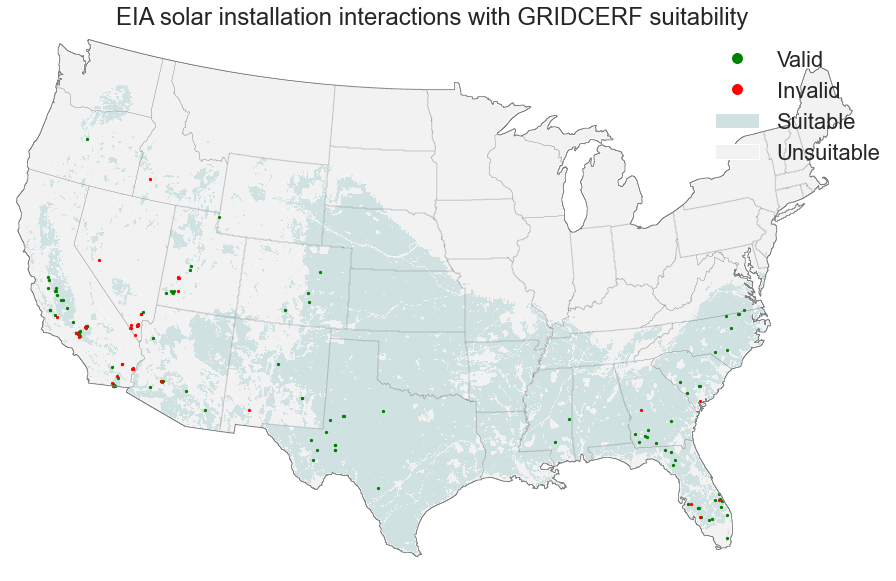

In [22]:
# generate plot
sns.set(font_scale=2) 

fig, ax = plt.subplots(figsize=(20, 10))

plt.title("EIA solar installation interactions with GRIDCERF suitability")

suitable_color = "#d0e1e1"
unsuitable_color = "#f3f2f2"

cmap = ListedColormap([suitable_color, unsuitable_color])

with rasterio.open(cerf_suitability_masked_file) as src:
    
    # boundary_gdf.plot(ax=ax, facecolor='lightgray')
    show(src, ax=ax, cmap=cmap) #, interpolation='none', ax=ax)
    states_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.2)
    boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)
    suitable_power_plants.plot(ax=ax, color='green', markersize=5)
    unsuitable_power_plants.plot(ax=ax, color='red', markersize=5)

    # construct legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=12, label='Valid'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Invalid'),
                       Patch(facecolor=suitable_color, label='Suitable'),
                       Patch(facecolor=unsuitable_color, label='Unsuitable')]

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(1.05, 1),
              facecolor="white",
              frameon=False)

    ax.set_axis_off()

    sns.set(font_scale=1)

n_suitable = suitable_power_plants.shape[0]
n_unsuitable = unsuitable_power_plants.shape[0]
    
print(f"There are {n_suitable} valid power plants.")
print(f"There are {n_unsuitable} invalid power plants.\n")


### Fraction of invalidities caused by each layer

This breaks down validity by using only on layer at a time as the exclusion layer.  For example, if `cerf_nlcd_wetlands_1km_2019_conus.tif` were the only exclusion layer in use, 66 power plants would be considered invalid out of all 497 power plants investigated.


In [23]:
layer_specific_diagnostics.sort_values(by='fraction', ascending=False)


,layer,invalid,valid,fraction
23,combined_common_suitability_layers,36,118,0.233766
15,gridcerf_blm_surface_management_agency_areas.tif,21,133,0.136364
8,gridcerf_nps_historic_trails_conus.tif,7,147,0.045455
0,gridcerf_wdpa_state_protected_lands_conus.tif,5,149,0.032468
3,gridcerf_usfws_critical_habitat_conus.tif,3,151,0.019481
21,gridcerf_srtm_slope_10pct_or_less.tif,2,152,0.012987
1,gridcerf_blm_nlcs_national_monument_conus.tif,2,152,0.012987
4,gridcerf_usgs_padus_class_1_to_2_conus.tif,1,153,0.006494
18,gridcerf_nps_scenic_trails_conus.tif,1,153,0.006494
13,gridcerf_nlcd_wetlands_conus.tif,1,153,0.006494


##### Plot bar

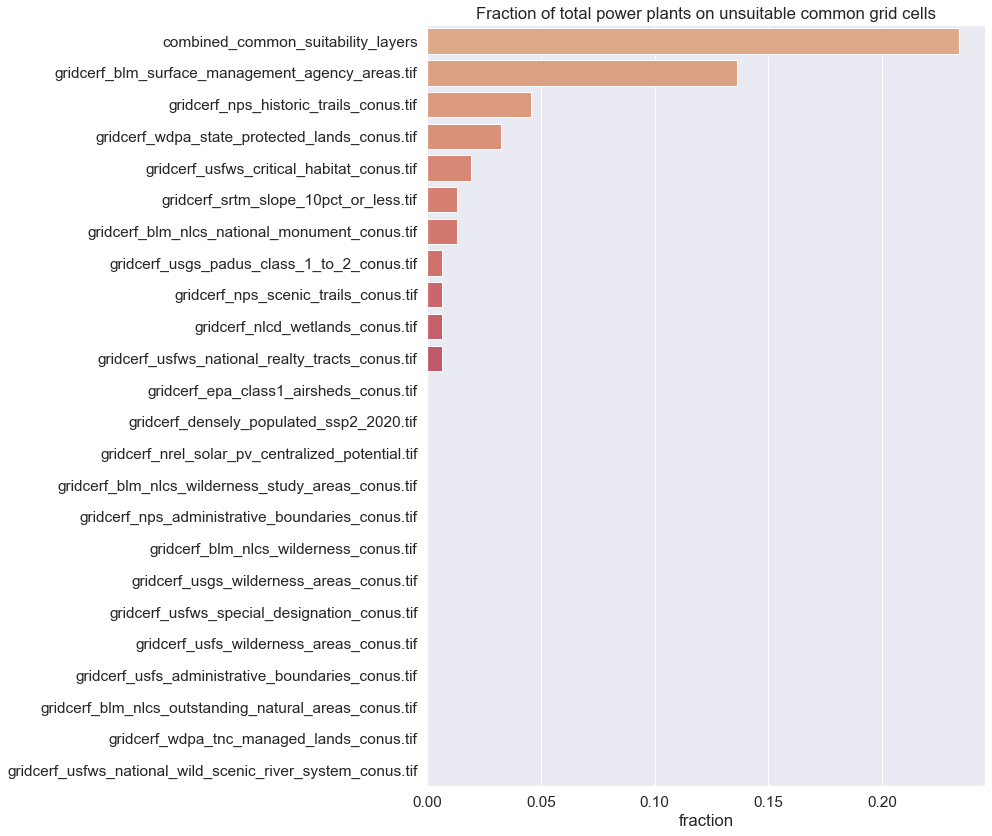

In [24]:
display_df = layer_specific_diagnostics.sort_values(by='fraction', ascending=False).copy()

sns.set(font_scale=1.4) 

fig, ax = plt.subplots(figsize=(10, 14))

ax = sns.barplot(x="fraction", y="layer", data=display_df, palette="flare")

ax.set(ylabel=None, 
       title='Fraction of total power plants on unsuitable common grid cells')

sns.set(font_scale=1) 


### Composition of invalid plants

In [25]:
# remove aggregate common metric
layer_composition = layer_specific_diagnostics.loc[layer_specific_diagnostics['layer'] != 'combined_common_suitability_layers'].copy()



In [26]:
# calculate the fraction of invalid by layer to the total number of unsuitable power plants (this number is lower than
#  the sum of invalid in this data frame because multiple layers can cause unsuitability to occur for each grid cell)
layer_composition['contribution_to_invalid'] = layer_composition['invalid'] / n_unsuitable

layer_composition.sort_values(by='contribution_to_invalid', ascending=False)


,layer,invalid,valid,fraction,contribution_to_invalid
15,gridcerf_blm_surface_management_agency_areas.tif,21,133,0.136364,0.583333
8,gridcerf_nps_historic_trails_conus.tif,7,147,0.045455,0.194444
0,gridcerf_wdpa_state_protected_lands_conus.tif,5,149,0.032468,0.138889
3,gridcerf_usfws_critical_habitat_conus.tif,3,151,0.019481,0.083333
21,gridcerf_srtm_slope_10pct_or_less.tif,2,152,0.012987,0.055556
1,gridcerf_blm_nlcs_national_monument_conus.tif,2,152,0.012987,0.055556
4,gridcerf_usgs_padus_class_1_to_2_conus.tif,1,153,0.006494,0.027778
18,gridcerf_nps_scenic_trails_conus.tif,1,153,0.006494,0.027778
17,gridcerf_usfws_national_realty_tracts_conus.tif,1,153,0.006494,0.027778
13,gridcerf_nlcd_wetlands_conus.tif,1,153,0.006494,0.027778


##### Plot

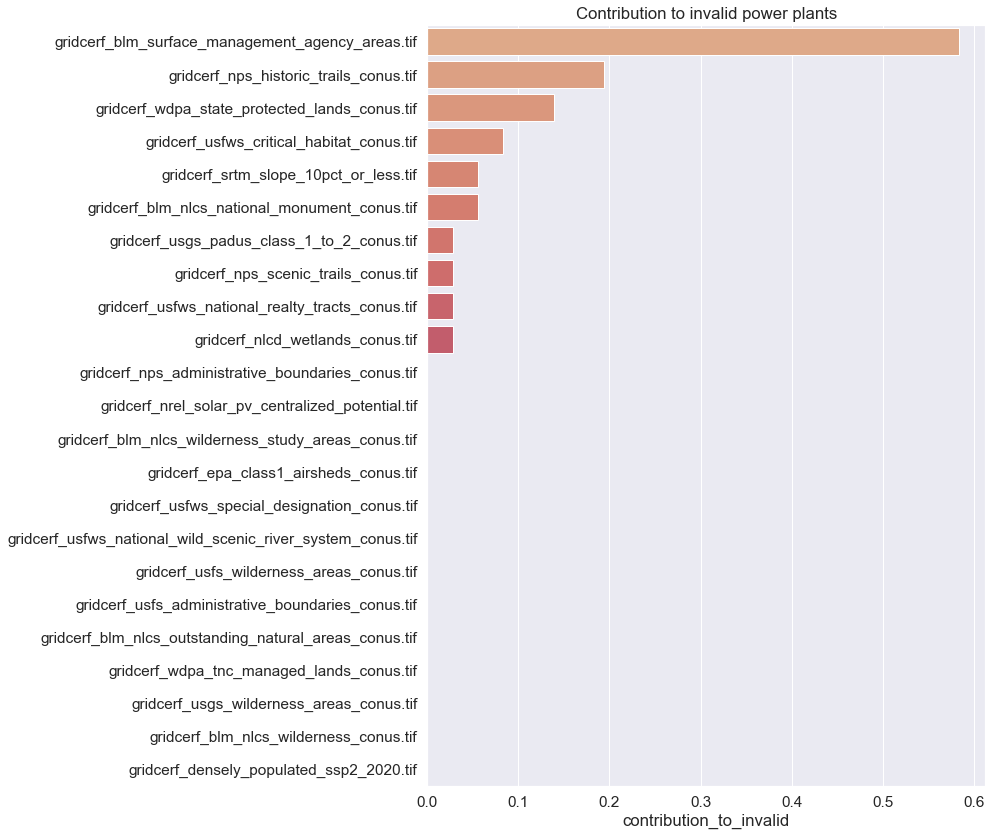

In [27]:
display_comp_df = layer_composition.sort_values(by='contribution_to_invalid', ascending=False).copy()

sns.set(font_scale=1.4) 

fig, ax = plt.subplots(figsize=(10, 14))

ax = sns.barplot(x="contribution_to_invalid", y="layer", data=display_comp_df, palette="flare")

ax.set(ylabel=None, 
       title='Contribution to invalid power plants')

sns.set(font_scale=1) 


### Determine the number of invalid power plants for each state

In [28]:
state_list = states_gdf['ObjectID'].unique()

state_d = {'state_name': [], 'invalid': [], 'valid': [], 'fraction': []}

with rasterio.open(cerf_suitability_file) as src:

    for i in state_list:

        target_state_gdf = states_gdf.loc[states_gdf['ObjectID'] == i].copy()

        state_power_plant_mask = power_plant_gdf.within(target_state_gdf.geometry.values[0])

        state_power_plant = power_plant_gdf.loc[state_power_plant_mask].copy()

        state_power_plant['xcoord'] = state_power_plant.geometry.x
        state_power_plant['ycoord'] = state_power_plant.geometry.y

        state_coords = [(x,y) for x, y in zip(state_power_plant['xcoord'], state_power_plant['ycoord'])]
        
        n_power_plants_state = len(state_coords)
        
        # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
        state_extract_suitability_at_points = [int(i[0]) for i in src.sample(state_coords)]
        
        # get the count of unsuitable designations
        n_unsuitable_plants_state = len([i for i in state_extract_suitability_at_points if i == 1])
        
        n_suitable_plants_state = n_power_plants_state - n_unsuitable_plants_state
        
        state_d['state_name'].append(i)
        state_d['invalid'].append(n_unsuitable_plants_state)
        state_d['valid'].append(n_suitable_plants_state)
        
        if n_unsuitable_plants_state == 0 or n_power_plants_state == 0:
            state_d['fraction'].append(0)
        else:
            state_d['fraction'].append(n_unsuitable_plants_state / n_power_plants_state)

states_diag_df = pd.DataFrame(state_d)


##### Plot map

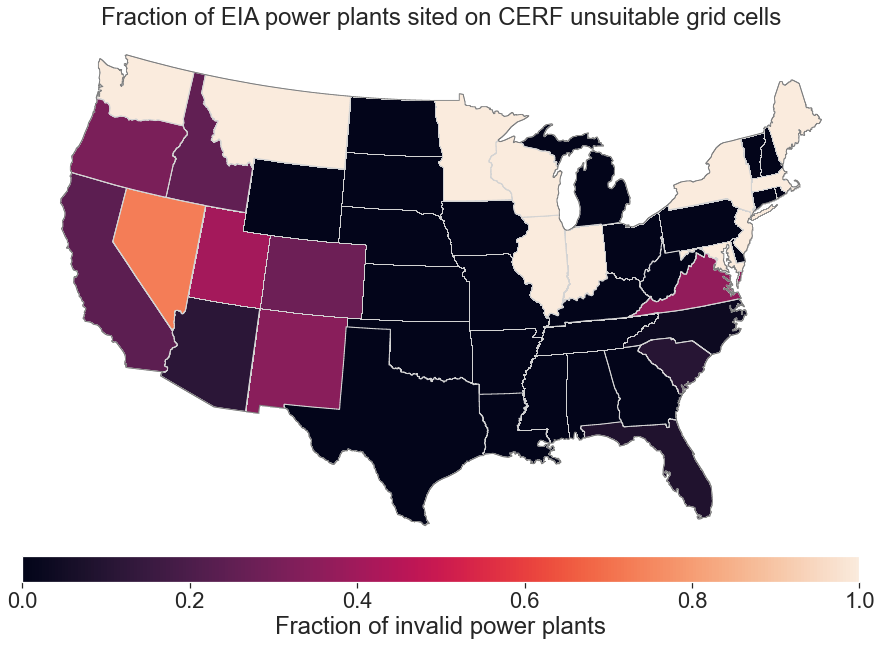

In [29]:
# get a dictionary of state ids to invalid fraction
states_eval = states_diag_df.copy()
states_eval.set_index('state_name', inplace=True)
state_lookup = states_eval['fraction'].to_dict()

# apply fraction to the states geodataframe
states_gdf['fraction'] = states_gdf['ObjectID'].map(state_lookup)

# plot map
sns.set(font_scale=2) 

fig, ax = plt.subplots(1, 1, figsize=(15, 20))

plt.title("Fraction of EIA power plants sited on CERF unsuitable grid cells")

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

s = states_gdf.plot(column='fraction', 
                ax=ax,
                edgecolor='lightgrey',
                legend=True,
                legend_kwds={'label': "Fraction of invalid power plants", 
                             'orientation': "horizontal"},
                cax=cax)

boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)

ax.set_axis_off()

sns.set(font_scale=1) 


##### Plot bar

### Prepare data for states (y-axis) to layers (x-axis) for fraction of invalid power plants

In [30]:
state_list = states_gdf['ObjectID'].unique()

heat_df = pd.DataFrame({'state_name': state_list})

head_d = {}

for raster in raster_list:
    
    base_name = os.path.basename(raster).lower()

    with rasterio.open(raster) as src:

        l = []
        
        for i in state_list:

            target_state_gdf = states_gdf.loc[states_gdf['ObjectID'] == i].copy()

            state_power_plant_mask = power_plant_gdf.within(target_state_gdf.geometry.values[0])

            state_power_plant = power_plant_gdf.loc[state_power_plant_mask].copy()

            state_power_plant['xcoord'] = state_power_plant.geometry.x
            state_power_plant['ycoord'] = state_power_plant.geometry.y

            state_coords = [(x,y) for x, y in zip(state_power_plant['xcoord'], state_power_plant['ycoord'])]

            n_power_plants_state = len(state_coords)

            # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
            state_extract_suitability_at_points = [int(i[0]) for i in src.sample(state_coords)]

            # get the count of unsuitable designations
            n_unsuitable_plants_state = len([i for i in state_extract_suitability_at_points if i == 1])

            n_suitable_plants_state = n_power_plants_state - n_unsuitable_plants_state
            
            # fraction of invalid plants for the target state per layer
            if n_unsuitable_plants_state == 0 or n_power_plants_state == 0:
                l.append(0)
            else:
                l.append(n_unsuitable_plants_state / n_power_plants_state)

        heat_df[base_name] = l



### Calculate the distance to the nearest suitable grid cell for invalid data

### Create the proximity of invalid plants to a suitable grid cell

Currently, I do this in ArcMap using the following procedure:
- add the created `<mydir>/temp/cerf_common_suitability_landmask.tif` file
- add `<mydir>/results/unsuitable_power_plants_solar.shp`
- Run the `Set Null` tool using `VALUE = 1` and the suitability raster as the input and constant
- Run the `Euclidean Distance` tool on the set null output raster
- Run the `Extract Values to Points` to using the output of Euclidean distance and the unsuitable points
- Save the output as `<mydir>/results/unsuitable_power_plants_dist_solar.shp`


<AxesSubplot:>

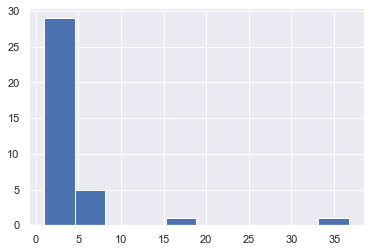

In [32]:
prox_gdf = gpd.read_file(os.path.join(validation_dir, 'results', 'unsuitable_power_plants_dist_solar.shp'))

prox_gdf['dist_to_suit_km'] = prox_gdf['RASTERVALU'] / 1000

# plot histogram
prox_gdf['dist_to_suit_km'].hist()


In [33]:
# there were two outliers
outliers = prox_gdf.loc[prox_gdf["RASTERVALU"] == 0].copy()

# remove the outliers and report them separately 
prox_gdf_no_outliers = prox_gdf.loc[prox_gdf["RASTERVALU"] > 0].copy()



In [34]:
n_within_1km = prox_gdf.loc[prox_gdf['dist_to_suit_km'] <=1 ].shape[0]

rmse = str(np.around(np.sqrt((prox_gdf['dist_to_suit_km'].values**2).mean()), 2))

print(f"There are {n_within_1km} invalid plants within 1-km of a suitable grid cell.")
print(f"The RMSE of all invalid power plants distance to a near suitability grid cell is:  {rmse}-km")
print(f"Technologies having an invalid designation:  {', '.join(prox_gdf['PrimSource'].unique().tolist())}")

dist_max = prox_gdf['dist_to_suit_km'].max()

print(f"The maximum distance from an invalid grid cell to a suitable one is {dist_max}-km")


There are 18 invalid plants within 1-km of a suitable grid cell.
The RMSE of all invalid power plants distance to a near suitability grid cell is:  7.32-km
Technologies having an invalid designation:  solar
The maximum distance from an invalid grid cell to a suitable one is 36.6879-km


#### Bin distance to suitability

In [35]:
unsuitable_1 = prox_gdf_no_outliers.loc[prox_gdf_no_outliers['dist_to_suit_km'] <= 1.0].copy()

unsuitable_2 = prox_gdf_no_outliers.loc[(prox_gdf_no_outliers['dist_to_suit_km'] > 1.0) &
                                          (prox_gdf_no_outliers['dist_to_suit_km'] <= 2.0)].copy()

unsuitable_3 = prox_gdf_no_outliers.loc[(prox_gdf_no_outliers['dist_to_suit_km'] > 2.0) &
                                          (prox_gdf_no_outliers['dist_to_suit_km'] <= 5.0)].copy()

unsuitable_4 = prox_gdf_no_outliers.loc[prox_gdf_no_outliers['dist_to_suit_km'] > 5.0].copy()


In [36]:
unsuitable_4.dist_to_suit_km.max()

36.6879

#### Plot map

/Users/d3y010/.pyenv/versions/py3.9.2_cerf/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


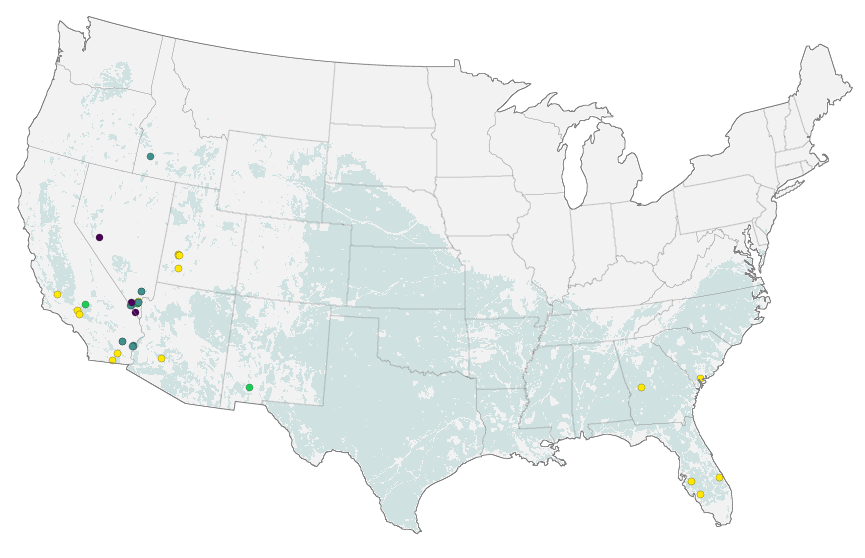

In [37]:
# generate plot
sns.set(font_scale=2) 

fig, ax = plt.subplots(figsize=(20, 10))

# plt.title("EIA power plant interactions with CERF common suitability")

suitable_color = "#d0e1e1"
unsuitable_color = "#f3f2f2"

# cmap = ListedColormap([suitable_color, "#00ff0000"])
cmap = ListedColormap([suitable_color, unsuitable_color])

# cmap_110 = ListedColormap(["#7C56EF50", unsuitable_color])

# colorblind friendly colors
bin_1_color = '#FFE700'
bin_2_color = '#1ACD54'
bin_3_color = '#40908E'
bin_4_color = '#4B0057'


with rasterio.open(cerf_suitability_masked_file) as src:
    
    show(src, ax=ax, cmap=cmap) #, interpolation='none', ax=ax)
    states_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.2)
    boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)

    # bin 1
    unsuitable_1.plot(ax=ax, color=bin_1_color, markersize=50, marker='o', linewidth=0.2, edgecolor='black')

    # bin 2
    unsuitable_2.plot(ax=ax, color=bin_2_color, markersize=50, marker='o', linewidth=0.2, edgecolor='black')

    # bin 3
    unsuitable_3.plot(ax=ax, color=bin_3_color, markersize=50, marker='o', linewidth=0.2, edgecolor='black')

    # bin 4
    unsuitable_4.plot(ax=ax, color=bin_4_color, markersize=50, marker='o', linewidth=0.2, edgecolor='black')
    
    # outliers
    outliers.plot(ax=ax, color="black", markersize=100, marker="*", linewidth=0.2, edgecolor='black')

    ax.set_axis_off()

    sns.set(font_scale=1)

    
output_fig = os.path.join(validation_dir, 'results', 'validation_map_solar.png')

plt.savefig(output_fig, dpi=350, facecolor='w', edgecolor='w',
            orientation='portrait', format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            metadata=None)



In [38]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [39]:
prox_gdf_no_outliers['bin'] = 0

prox_gdf_no_outliers['bin'] = np.where(prox_gdf_no_outliers['dist_to_suit_km'] <= 1.0, 
                           1, 
                           prox_gdf_no_outliers['bin'])

prox_gdf_no_outliers['bin'] = np.where((prox_gdf_no_outliers['dist_to_suit_km'] > 1.0) &
                           (prox_gdf_no_outliers['dist_to_suit_km'] <= 2.0), 
                           2, 
                           prox_gdf_no_outliers['bin'])

prox_gdf_no_outliers['bin'] = np.where((prox_gdf_no_outliers['dist_to_suit_km'] > 2.0) &
                           (prox_gdf_no_outliers['dist_to_suit_km'] <= 5.0), 
                           3, 
                           prox_gdf_no_outliers['bin'])

prox_gdf_no_outliers['bin'] = np.where(prox_gdf_no_outliers['dist_to_suit_km'] > 5.0, 
                           4, 
                           prox_gdf_no_outliers['bin'])

freq = prox_gdf_no_outliers.bin.value_counts()

dk = pd.DataFrame({'bin': [1, 2, 3, 4], 
                   'count': [freq.iloc[0], 
                             freq.iloc[1], 
                             freq.iloc[2], 
                             freq.iloc[3]
                            ],
                   'group': [0, 0, 0, 0]})

dk


,bin,count,group
0,1,18,0
1,2,11,0
2,3,4,0
3,4,3,0


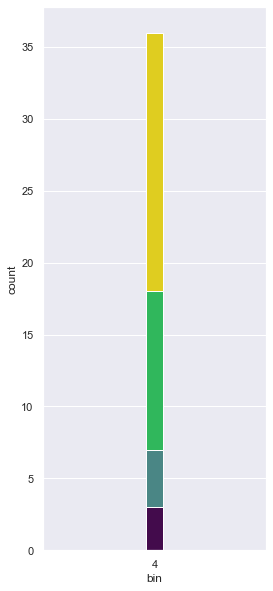

In [40]:
def change_width(ax, new_value) :
    
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


plt.figure(figsize=(4, 10))

bin_1_color = '#FFE700'
bin_2_color = '#1ACD54'
bin_3_color = '#40908E'
bin_4_color = '#4B0057'

width = [2]

bar1 = sns.barplot(x="bin",  y="count", data=dk.loc[dk['bin'] >= 1].groupby('group').sum().reset_index(), color=bin_1_color)
bar2 = sns.barplot(x="bin",  y="count", data=dk.loc[dk['bin'] >= 2].groupby('group').sum().reset_index(), color=bin_2_color)
bar3 = sns.barplot(x="bin",  y="count", data=dk.loc[dk['bin'] >= 3].groupby('group').sum().reset_index(), color=bin_3_color)
bar4 = sns.barplot(x="bin",  y="count", data=dk.loc[dk['bin'] >= 4].groupby('group').sum().reset_index(), color=bin_4_color)

change_width(bar1, .08)

